In [1]:
#=======Import Library========
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
import numpy as np
from scipy.integrate import solve_ivp
from itertools import product
from copy import deepcopy as cp
from sklearn.linear_model import Lasso   
from sklearn.exceptions import ConvergenceWarning
import warnings  
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, TFSMLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.regularizers import l2, l1
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import AdamW, Adam, SGD, Lion
import copy, h5py
from copy import deepcopy as cp
import pandas as pd
import os,sys
sys.path.append('.')
from contour import *  # contour
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

In [2]:
# Helper function for monomial exponents (not provided in the original code)
def monomial_exponents(num_features, order):
    """
    Generate all possible monomial exponents up to a given order for the state variables.
    
    Parameters:
        num_features : int
            The number of features (state variables).
        order : int
            The maximum polynomial degree.
    
    Returns:
        exponents : list of tuples
            Each tuple represents a monomial (exponent combination) for the state variables.
    """

    # Generate all combinations of exponents for the monomials
    exponents = ([exp for exp in product(range(order+1), repeat=num_features)])
    return exponents

# Function to generate the candidate library matrix Θ for SINDy (Sparse Identification of Nonlinear Dynamical Systems)
def Theta(x_train, t_train, order=5, usePolX=True, usePolT=False, useTriX=False, useTriT=False, outputLog=False):
    """
    Generate the candidate library matrix (Θ) for Sparse Identification of Nonlinear Dynamical Systems (SINDy).
    
    Parameters:
        x_train : ndarray, shape (n_samples, n_features)
            The state variables (e.g., x, y, z values over time).
        t_train : ndarray, shape (n_samples,)
            The time points corresponding to the states.
        order : int
            The maximum polynomial degree for terms in x and t.
        usePolX : bool
            Whether to include polynomial terms in x (state variables).
        usePolT : bool
            Whether to include polynomial terms in t (time).
        useTriX : bool
            Whether to include sine and cosine terms for monomials in x.
        useTriT : bool
            Whether to include sine and cosine terms for polynomials in t.
        outputLog : bool
            Whether to output log.   

    Returns:
        mat_theta : ndarray, shape (n_samples, Theta_columns)
            The candidate library matrix Θ constructed from the state variables and time.
    """
   # Dimensions of the input data
    num_samples, num_features = x_train.shape  # Number of samples and features
    powers = monomial_exponents(num_features, order)  # Monomial exponents for features   
    # Initialize the total number of columns in Θ based on the flags provided
    Theta_columns = 0     
    # Determine the number of columns based on which terms to include
    if(usePolX): Theta_columns += len(powers)  # Polynomial terms in x
    if(usePolT): Theta_columns += order        # Time polynomial terms
    if(useTriX): Theta_columns += 2 * num_features * len(powers)  # Sin and Cos of x monomials
    if(useTriT): Theta_columns += 2 * order    # Sin and Cos of time
    # Initialize the Θ matrix (n_samples x Theta_columns)
    mat_theta = np.zeros((num_samples, Theta_columns))
    # Index for tracking columns in mat_theta
    col = 0
    if (outputLog==True): print(f"\nBuilding Θ matrix with {num_samples} samples and {Theta_columns} columns.")
    if (usePolX):
        # 1. Polynomial terms in x
        if (outputLog==True): print("Including polynomial terms in x...")
        for power in powers:
            # Create the polynomial term as a string for logging
            poly_term = create_polynomial_string(power)
            # Multiply the corresponding columns in x_train raised to the power
            mat_theta[:, col] = np.prod(np.power(x_train, power), axis=1)
            col += 1
            if (outputLog==True): print(f"  Polynomial term ({poly_term}): Column {col-1}") 
    
    if (usePolT):
        # 2. Polynomial terms in t
        if (outputLog==True): print("Including polynomial terms in t...")
        for deg in range(1, order + 1):
            # Create the polynomial term for time as a string
            poly_term = f"t^{deg}"
            # Add polynomial terms for time t (t^1, t^2, ..., t^order)
            mat_theta[:, col] = np.power(t_train, deg)
            col += 1
            if (outputLog==True): print(f"  Polynomial term ({poly_term}): Column {col-1}")   

    if (useTriX):
        # 3. Sin and Cos of monomials in x
        if (outputLog==True): print("Including sine and cosine terms for monomials in x...")
        for feature_idx in range(num_features):
            for power in powers:
                # Apply sin and cos for each monomial term in x
                mat_theta[:, col] = np.sin(np.power(x_train[:, feature_idx], power[feature_idx]))
                col += 1
                mat_theta[:, col] = np.cos(np.power(x_train[:, feature_idx], power[feature_idx]))
                col += 1
                # Create a readable polynomial term for sin/cos
                poly_term = create_polynomial_string(power)
                if (outputLog==True): print(f"  sin/cos term for {poly_term} (feature {feature_idx}): Columns {col-2} and {col-1}")  
      
    if (useTriT):
        # 4. Sin and Cos of time
        if (outputLog==True): print("Including sine and cosine terms for time...")
        for deg in range(1, order + 1):
            # Create the polynomial term for time as a string for sin/cos
            poly_term = f"t^{deg}"
            # Apply sin and cos for each polynomial term in time
            mat_theta[:, col] = np.sin(np.power(t_train, deg))
            col += 1
            mat_theta[:, col] = np.cos(np.power(t_train, deg))
            col += 1
            #print(f"  sin/cos term for {poly_term}: Columns {col-2} and {col-1}")
        if (outputLog==True): print(f"\nFinished building Θ matrix with {col} columns.")
    mat_theta = np.nan_to_num(mat_theta, nan=0.0, posinf=1e10, neginf=-1e10)    
    return mat_theta            
        

def create_polynomial_string(power):
    """
    Converts a tuple of exponents to a readable polynomial string.
    
    Parameters:
        power : tuple
            A tuple of exponents, e.g., (2, 1) for x^2 * y^1.
    
    Returns:
        poly_term : str
            A string representing the polynomial, e.g., "x^2y".
    """
    poly_term = ""
    for i, p in enumerate(power):
        if p > 0:
            poly_term += f"x{i+1}^{p}" if p > 1 else f"x{i+1}"
    return poly_term if poly_term else "1"  # Return "1" for constant term


# Adaptive Lasso implementation with logging
def alasso(RHS, LHS, alpha, delta=1.0, max_iter=100, lasso_tol=1e-10, alasso_tol=1e-12):
    """
    Adaptive Lasso using iterative reweighting with detailed logging.

    Parameters:
        RHS : ndarray, shape (n_samples, n_features)
            The Theta matrix (candidate functions).
        LHS : ndarray, shape (n_samples,)
            The time derivative of a single state variable.
        alpha : float
            Regularization parameter for Lasso.
        delta : float
            Power of weights in adaptive reweighting (typically 1.0).
        max_iter : int
            Number of outer iterations for adaptive updates.
        lasso_tol : float
            Tolerance for inner Lasso solver.
        alasso_tol : float
            Convergence threshold for weight change.

    Returns:
        coef_ : ndarray, shape (n_features,)
            Final sparse coefficients.
    """
    n_samples, n_features = RHS.shape
    weights = np.ones(n_features)
    
    # Printing header for log
    print(f"\n{'Iteration':<10}{'Weight Δ':<15}{'Coef Δ':<15}{'L1 Norm':<15}{'Max Coef':<15}{'Nonzero Coefs':<15}")
    print('-' * 80)

    
    for iter_num in range(max_iter):
        prev_weights = cp(weights)

        # Re-weight design matrix
        RHS_w = RHS / weights[np.newaxis, :]

        # Solve Lasso on weighted features
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000, tol=lasso_tol)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            lasso.fit(RHS_w, LHS)

        # Recover unweighted coefficients
        coef_ = lasso.coef_ / weights

        # Update weights
        weights = 1.0 / (np.abs(coef_) ** delta + 1e-8)  # Add epsilon to avoid division by zero

        # Calculate L1 norm of coefficients (for convergence check)
        l1_norm = np.linalg.norm(coef_, 1)
        
        # Calculate max coefficient value for logs
        max_coef = np.max(np.abs(coef_))
        
        # Calculate number of nonzero coefficients
        nonzero_coef = np.sum(coef_ != 0)

        # Log current iteration details
        weight_change = np.mean((weights - prev_weights) ** 2)
        coef_change = np.mean(np.abs(coef_ - prev_weights))

        print(f"{iter_num:<10}{weight_change:<15.3e}{coef_change:<15.3e}{l1_norm:<15.3e}{max_coef:<15.3e}{nonzero_coef:<15}")

        # Check convergence based on weight change
        if weight_change < alasso_tol:
            print(f"Converged after {iter_num} iterations")
            break

    return coef_

In [3]:
# -------------------------------
# Autoencoder Model
# -------------------------------
# Encoder-only module
class Encoder(nn.Module):
    activation: str = 'tanh'

    @nn.compact
    def __call__(self, x):
        act = getattr(nn, self.activation)
        x = act(nn.Dense(1024)(x))
        x = act(nn.Dense(128)(x))
        x = act(nn.Dense(40)(x))
        x = act(nn.Dense(15)(x))
        x = act(nn.Dense(2)(x))  # bottleneck
        return x

# Decoder-only module
class Decoder(nn.Module):
    activation: str = 'tanh'

    @nn.compact
    def __call__(self, x):
        act = getattr(nn, self.activation)
        x = act(nn.Dense(15)(x))
        x = act(nn.Dense(40)(x))
        x = act(nn.Dense(128)(x))
        x = act(nn.Dense(1024)(x))
        x = nn.Dense(16384)(x)  # output layer, no activation
        return x
class FullAutoencoder(nn.Module):
    activation: str = 'tanh'

    def setup(self):
        self.encoder = Encoder(activation=self.activation)
        self.decoder = Decoder(activation=self.activation)

    def __call__(self, x):
        z = self.encoder(x)
        return self.decoder(z)        

# -------------------------------
# Create Training State
# -------------------------------
# Create the training state with Adam optimizer
def create_train_state(rng, model, input_shape, learning_rate=1e-4):
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# L2-regularized training step
@jax.jit
def train_step(state, batch, l2_reg=0):
    def loss_fn(params):
        preds = state.apply_fn({'params': params}, batch)
        mse = jnp.mean((preds - batch) ** 2)
        l2_loss = sum([jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)])
        return mse + l2_reg * l2_loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

# -------------------------------
# Training Function
# -------------------------------
def train_autoencoder(X, epochs=50000, batch_size=64, model_name="named_autoencoder"):
    import os
    best_val_loss = float('inf')

    input_dim = X.shape[1]
    rng = jax.random.PRNGKey(0)  # ✅ Initial random key

    model = FullAutoencoder()
    state = create_train_state(rng, model, (1, input_dim))

    # Split dataset
    X_train, X_val = train_test_split(X, test_size=0.3, random_state=1)

    save_dir = os.path.abspath('./jax_model/')
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        # ✅ Advance RNG for permutation to avoid static batches
        rng, input_rng = jax.random.split(rng)

        permutation = jax.random.permutation(input_rng, X_train.shape[0])
        X_train = X_train[permutation]

        for i in range(0, X_train.shape[0], batch_size):
            batch = X_train[i:i+batch_size]
            state = train_step(state, batch, l2_reg=0)  # ✅ Add regularization

        # Validation loss
        val_preds = model.apply({'params': state.params}, X_val)
        val_loss = jnp.mean((val_preds - X_val) ** 2)
        print(f"Epoch {epoch+1} - Val MSE: {val_loss:.6f}")

        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            #checkpoints.save_checkpoint(ckpt_dir=save_dir,target=state,step=epoch,prefix=model_name + "_best",
             #                           overwrite=True)
            save_dir = os.path.abspath('./jax_model/')
            os.makedirs(save_dir, exist_ok=True)
            checkpoints.save_checkpoint(ckpt_dir=save_dir,target=state,step=epoch,prefix=model_name + "_best",
                                        overwrite=True)

    return state, model

def load_autoencoder_model(model_name: str, input_dim=16384):
    # Recreate model
    model = FullAutoencoder()
    rng = jax.random.PRNGKey(0)
    variables = model.init(rng, jnp.ones((1, input_dim)))
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optax.adam(1e-3))

    # Load checkpoint
    ckpt_dir = os.path.abspath('./jax_model')
    state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, prefix=model_name)

    # Return full model + encoder/decoder
    encoder_model = Encoder()
    decoder_model = Decoder()

    return state, model, encoder_model, decoder_model  

In [4]:
filename='jax_model'
state, full_model, encoder_sae, decoder_sae = load_autoencoder_model(filename)
encoder_module, encoder_params = full_model.bind({'params': state.params}).encoder.unbind()
decoder_module, decoder_params = full_model.bind({'params': state.params}).decoder.unbind()
variables = {'params': state.params}

In [5]:
Un = np.load("data/Un.npy")[-2000:,:,:].reshape(2000,-1) 
Vn = np.load("data/Vn.npy")[-2000:,:,:].reshape(2000,-1) 
Xn = np.load("data/Xn.npy")
Yn = np.load("data/Yn.npy")

In [6]:
n_ts, N, k = 2000, 8192*2, 2
X = np.zeros((n_ts,N))
X[:,:] = np.hstack([Un,Vn])#Un[:,:]
X_avg = np.mean(X,axis=0)
Xrall = np.zeros((n_ts,N))
for i in range(0,n_ts):
  Xrall[i,:] = X[i,:]-X_avg
Xrall_sae = cp(Xrall)
X0_sae = cp(Xrall_sae)
min = np.min(X0_sae,axis=0)
max = np.max(X0_sae,axis=0)
X0_sae = X0_sae-min
X0_sae=X0_sae.reshape((X0_sae.shape[0],-1))
print(np.max(X0_sae))
print(np.min(X0_sae))
print(X0_sae.shape)
X0_sae3=cp(X0_sae)

2.7363488850142863
0.0
(2000, 16384)


In [7]:
r = encoder_module.apply(encoder_params, jnp.array(X0_sae))
decoded_data = decoder_module.apply(decoder_params, r)
#decoded_data = decoder_sae.predict(x_train)
reconstruct = np.zeros_like(decoded_data)
reconstruct = decoded_data + min+X_avg
ratio = 1-np.linalg.norm(reconstruct-X)/np.linalg.norm(X)
print(ratio)

0.9973117393601496


In [8]:
save_dir = './models'
os.makedirs(save_dir, exist_ok=True)  # Create it if not exists
np.save('./models/latent_stacked_auto_encoder_jax'+'.npy',r) 

In [35]:
x_train = np.load('models/latent_stacked_auto_encoder_jax'+'.npy')

In [36]:
Xor = cp(x_train)
r_min11 = np.min(Xor,axis=0)
r_max11 = np.max(Xor,axis=0)
for i in range(len(Xor)):
  Xor[i,:] = (2*Xor[i,:]-r_max11-r_min11)/(r_max11-r_min11)
for i in range(len(Xor)):
  for j in range(2):
    if np.isnan(Xor[i,j]):
      print(i,j)
print(Xor.shape)
print(Xor.max(),Xor.min())

(2000, 2)
1.0 -1.0000001


## PCA

In [33]:
sae_pca = PCA(n_components=2)
Xor2 = sae_pca.fit_transform(Xor)
print(Xor2.shape)
re_Xor = sae_pca.inverse_transform(Xor2)
print(1-np.linalg.norm(re_Xor-Xor)/np.linalg.norm(Xor))
r_min12 = np.min(Xor2,axis=0)
r_max12 = np.max(Xor2,axis=0)
for i in range(len(Xor2)):
  Xor2[i,:] = (2*Xor2[i,:]-r_max12-r_min12)/(r_max12-r_min12)
for i in range(len(Xor2)):
  for j in range(2):
    if np.isnan(Xor2[i,j]):
      print(i,j)
print(Xor2.shape)
print(Xor2.max(),Xor2.min())  

(2000, 2)
0.99999994
(2000, 2)
1.0 -1.0000001


In [37]:
dt = 0.05
r1 = cp(Xor[:,0])
r2 = cp(Xor[:,1])
print(r1.shape,)
data = np.zeros([len(r1)-2,2])
data[:,0] = r1[1:len(r1)-1]
data[:,1] = r2[1:len(r2)-1]           
x_train=cp(data)
print(x_train.max(), x_train.min())

(2000,)
1.0 -1.0000001192092896


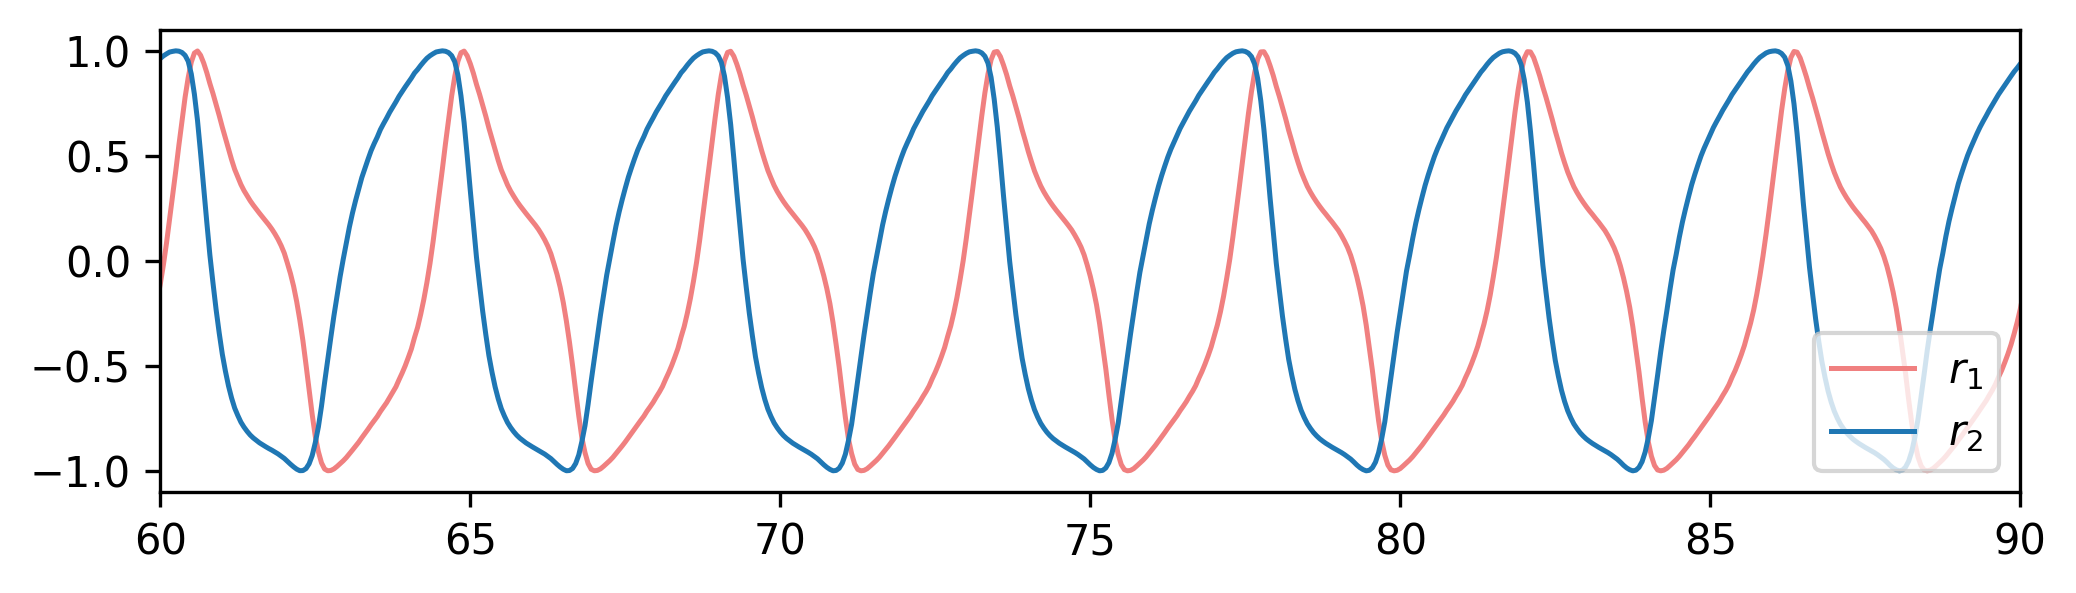

In [38]:
dt, t_0, t_end = 0.05, 0, 100
t_train = np.arange(t_0+dt, t_end-dt, dt)
t_train_span = (t_train[0], t_train[-1])

fig=plt.figure(dpi=300,figsize=(8,2))
plt.plot(t_train,x_train[:,0],label=r'$r_1$',lw=1.2,color='lightcoral')
plt.plot(t_train,x_train[:,1],label=r'$r_2$',lw=1.2)
plt.xlim([60,90])
plt.legend(loc='lower right')
plt.savefig(fname='Latent_space_SAE+POD_Jax.png', dpi=300)
plt.show()

In [39]:
x0_train=x_train[0,:]
print(x0_train.shape)
print(x0_train.max(), x0_train.min())

(2,)
0.9970185160636902 0.28835931420326233


In [41]:
# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T
print(dxdt.shape)

(1998, 2)


In [42]:
degree_list = [3]   # Try multiple degrees
alpha_list = [9e-5]  # Try multiple alphas
#Without PCA Implementation alpha: degree=7, alpha=3e-06
#With PCA Implementation alpha: degree=6, alpha=7e-05
# 🚀 Outer loop: grid search
# 🚀 Initialize tracking:
best_derivative_error = np.inf
best_traj_error = np.inf
best_config = None

In [43]:
delta=1.0
max_iter=100
lasso_tol=1e-5
for degree in degree_list:
    for alpha in alpha_list:

        print(f"\n=== Testing degree={degree}, alpha={alpha} ===")
        # 1️⃣ Build Theta:
        matrix_theta = Theta(x_train, t_train, degree, True, False, False, False)

        # 2️⃣ Fit Adaptive Lasso:
        coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
        for i in range(x_train.shape[1]):
            print(f"\nFitting variable {i} (degree={degree}, alpha={alpha})")
            coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha, delta, max_iter, lasso_tol)

        # 3️⃣ Compute derivative error (no integration yet!):
        xdot_sindy = matrix_theta @ coefficients

        derivative_error = np.linalg.norm(xdot_sindy - dxdt)
        relative_derivative_error = derivative_error / np.linalg.norm(dxdt)

        print(f"Derivative error = {derivative_error:.6e}")
        print(f"Relative derivative error = {relative_derivative_error:.6e}")

        dt = t_train[1] - t_train[0]
        x_manual = [x0_train]
        def f(x):
            theta_x = Theta(x.reshape(1, -1), np.array([0.0]), degree, True, False, False, False)
            return (theta_x @ coefficients).flatten()
        for t in t_train[:-1]:
            x_current = x_manual[-1]
            k1 = f(x_current)
            k2 = f(x_current + 0.5 * dt * k1)
            k3 = f(x_current + 0.5 * dt * k2)
            k4 = f(x_current + dt * k3)
            x_next = x_current + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
            x_manual.append(x_next)
        x_latent_sindy = np.array(x_manual)

        # 5️⃣ Compute trajectory error:
        if x_latent_sindy.shape[0] != x_train.shape[0]:
            print(f"⚠️ WARNING: shape mismatch — skipping trajectory error.")
            print(f"Until now Best Trajectory error = {best_traj_error:.6e}")
        else:
            traj_error = np.linalg.norm(x_latent_sindy - x_train)
            relative_traj_error = traj_error / np.linalg.norm(x_train)

            print(f"Trajectory error = {traj_error:.6e}")
            print(f"Relative trajectory error = {relative_traj_error:.6e}")
            print(f"Best Trajectory error = {best_traj_error:.6e}")
            print(x_train.max(), x_train.min())
            # 6️⃣ Update best result:
            if relative_traj_error < best_traj_error:
                best_traj_error = relative_traj_error
                best_config = (degree, alpha)
                print(f"\n🚀 New BEST TRAJECTORY config found! degree={degree}, alpha={alpha}, relative_traj_error={relative_traj_error:.6e}")


=== Testing degree=3, alpha=9e-05 ===

Fitting variable 0 (degree=3, alpha=9e-05)

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         2.500e+15      1.244e+00      1.442e+01      2.365e+00      12             
1         6.250e+14      2.500e+07      1.468e+01      2.442e+00      11             
2         4.602e-07      3.125e+07      1.469e+01      2.443e+00      11             
3         1.385e-09      3.125e+07      1.469e+01      2.443e+00      11             
4         4.180e-12      3.125e+07      1.469e+01      2.443e+00      11             
5         1.266e-14      3.125e+07      1.469e+01      2.443e+00      11             
Converged after 5 iterations

Fitting variable 1 (degree=3, alpha=9e-05)

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
-------------------------------------------------------------------------

In [44]:
# Final report:
print("\n=== GRID SEARCH COMPLETE ===")
print(f"✅ Best TRAJECTORY config: degree={best_config[0]}, alpha={best_config[1]}")
print(f"✅ Best trajectory error: {best_traj_error:.6e}")
print(f"\n=== Testing degree={degree}, alpha={alpha} ===")


=== GRID SEARCH COMPLETE ===
✅ Best TRAJECTORY config: degree=3, alpha=9e-05
✅ Best trajectory error: 1.028427e-01

=== Testing degree=3, alpha=9e-05 ===


In [45]:
if (len(degree_list)!=1):
    # 1️⃣ Build Theta:
    matrix_theta = Theta(x_train, t_train, best_config[0], True, False, False, False)
    # 2️⃣ Fit Adaptive Lasso:
    coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
    for i in range(x_train.shape[1]):
         print(f"\nFitting variable {i} (degree={best_config[0]}, alpha={best_config[1]})")
         coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], best_config[1], delta, max_iter, lasso_tol)
    # 3️⃣ Compute derivative error (no integration yet!):
    xdot_sindy = matrix_theta @ coefficients
    derivative_error = np.linalg.norm(xdot_sindy - dxdt)
    relative_derivative_error = derivative_error / np.linalg.norm(dxdt)
    print(f"Derivative error = {derivative_error:.6e}")
    print(f"Relative derivative error = {relative_derivative_error:.6e}")

    dt = t_train[1] - t_train[0]
    x_manual = [x0_train]
    def f(x):
        theta_x = Theta(x.reshape(1, -1), np.array([0.0]), best_config[0], True, False, False, False)
        return (theta_x @ coefficients).flatten()
    for t in t_train[:-1]:
        x_current = x_manual[-1]
        k1 = f(x_current)
        k2 = f(x_current + 0.5 * dt * k1)
        k3 = f(x_current + 0.5 * dt * k2)
        k4 = f(x_current + dt * k3)
        x_next = x_current + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        x_manual.append(x_next)
    x_latent_sindy = np.array(x_manual)

    # Compute trajectory error:
    if x_latent_sindy.shape[0] != x_train.shape[0]:
        print(f"⚠️ WARNING: shape mismatch — skipping trajectory error.")
    else:
        traj_error = np.linalg.norm(x_latent_sindy - x_train)
        relative_traj_error = traj_error / np.linalg.norm(x_train)
        print(f"Trajectory error = {traj_error:.6e}")
        print(f"Relative trajectory error = {relative_traj_error:.6e}")

In [46]:
re_r1=x_latent_sindy
for i in range(len(re_r1)):
  re_r1[i,:] = (re_r1[i,:]*(r_max11-r_min11)+r_max11+r_min11)/2

## For PCA recconstruction

In [21]:
re_r1=x_latent_sindy
for i in range(len(re_r1)):
  re_r1[i,:] = (re_r1[i,:]*(r_max12-r_min12)+r_max12+r_min12)/2
re_r2= sae_pca.inverse_transform(re_r1)
for i in range(len(re_r1)):
  re_r1[i,:] = (re_r2[i,:]*(r_max11-r_min11)+r_max11+r_min11)/2

In [47]:
n_ts, N, k = 2000, 8192*2, 2
X = np.zeros((n_ts,N))
X[:,:] = np.hstack([Un,Vn])#Un[-n_ts:,:]
X_avg = np.mean(X,axis=0)
Xrall = np.zeros((n_ts,N))
for i in range(0,n_ts):
  Xrall[i,:] = X[i,:]-X_avg
Xrall_sae = cp(Xrall)
X0_sae = cp(Xrall_sae)
min = np.min(X0_sae,axis=0)
max = np.max(X0_sae,axis=0)
X0_sae = X0_sae-min
X0_sae=X0_sae.reshape((X0_sae.shape[0],-1))

In [48]:
decoded_data = decoder_module.apply(decoder_params, jnp.array(re_r1))

In [49]:
Ux_reconstructed = np.zeros_like(decoded_data)
Ux_reconstructed = decoded_data+ X_avg + min 
Ux_reconstructed=Ux_reconstructed.reshape(n_ts-2,N)
Ux_data=cp(X)
Ux_true = Ux_data[1:2000-1,:].reshape(1998,-1) 
full_space_error = np.linalg.norm(Ux_reconstructed - Ux_true)
relative_full_space_error = 1-full_space_error / np.linalg.norm(Ux_true)
print(full_space_error)
print(relative_full_space_error)

226.19678
0.9475786348004275


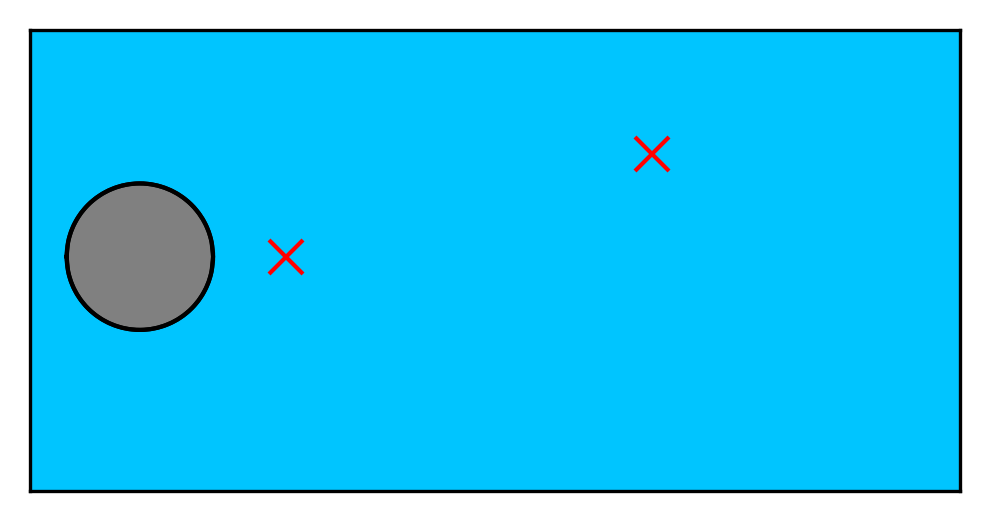

In [50]:
idx = 5486
Nx, Ny = 128, 64  # assuming these are your original grid sizes
idx1 = 5486
idx2 = 2272
idx1, idy1 = idx1//Ny, idx1%Ny
idx2, idy2 = idx2//Ny, idx2%Ny
x1, y1 = Xn[idx1], Yn[idy1]
x2, y2 = Xn[idx2], Yn[idy2]
contour((Ux_true).reshape(1998,2,128,64)[100,0,:,:]*0,'jet',[-0.8,1.7],Xn,Yn,markers=[(x1,y1),(x2,y2)])

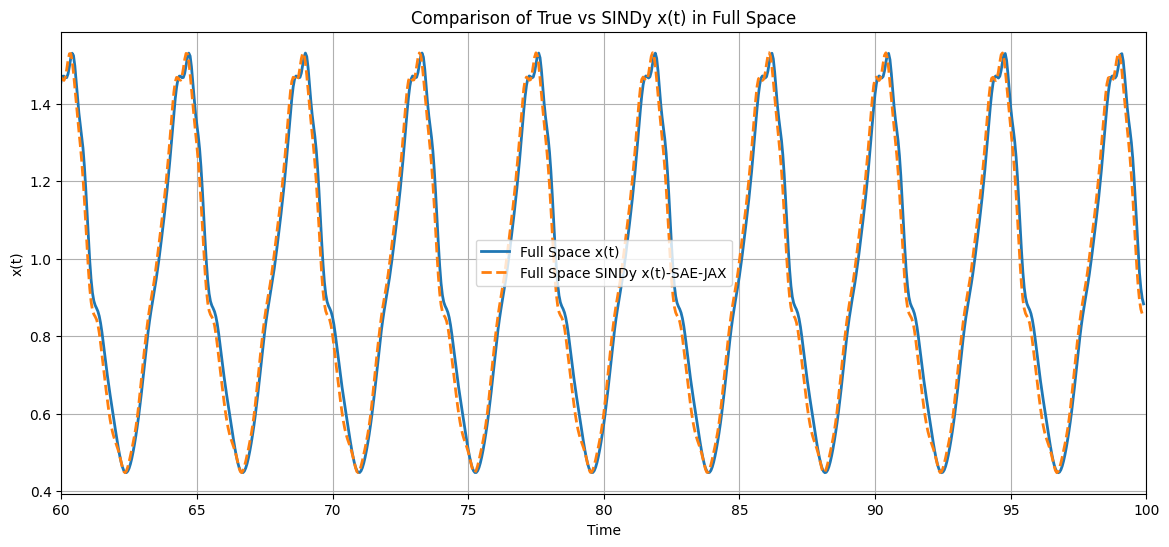

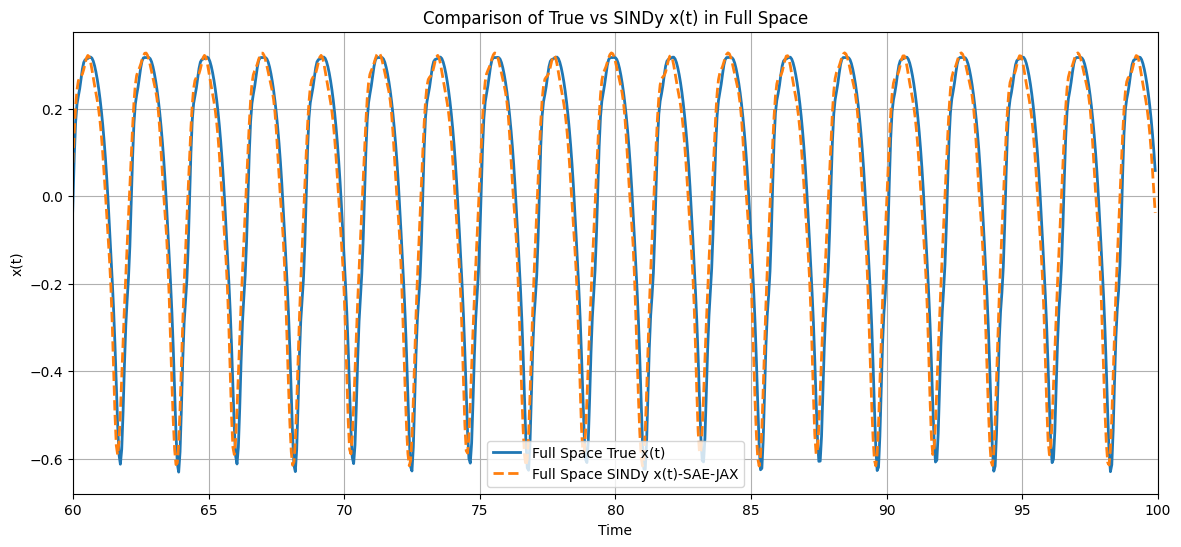

(1998, 2) (1998, 2) (1998,)


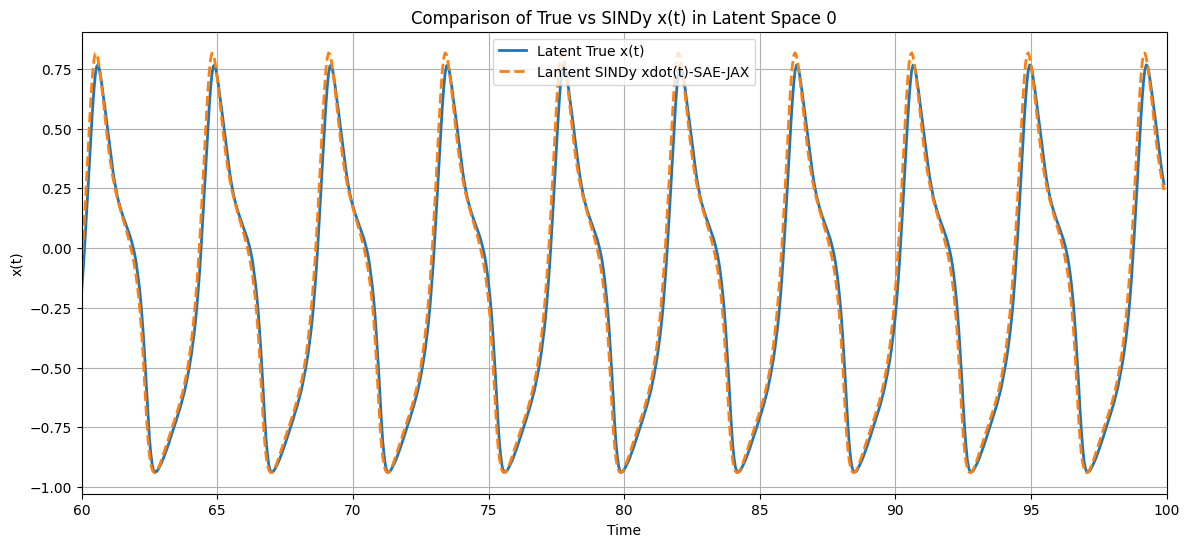

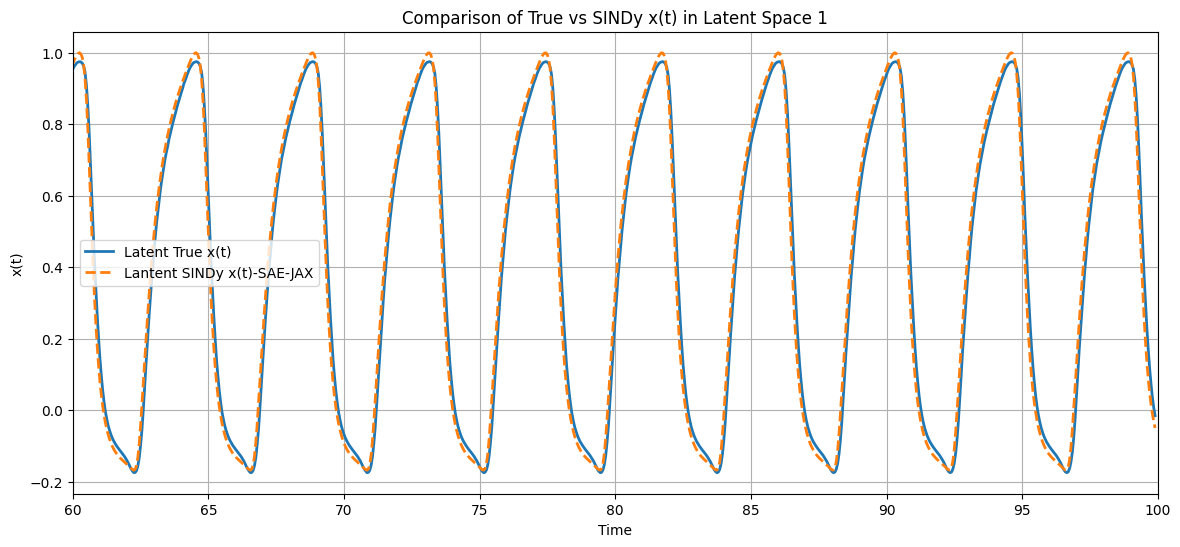

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(t_train, Ux_true[:, 5486], label='Full Space x(t)', linewidth=2)
plt.plot(t_train, Ux_reconstructed[:, 5486], '--', label='Full Space SINDy x(t)-SAE-JAX', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Full Space')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Full Space 1-SAE-JAX', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(t_train, Ux_true[:, 2272], label='Full Space True x(t)', linewidth=2)
plt.plot(t_train, Ux_reconstructed[:, 2272], '--', label='Full Space SINDy x(t)-SAE-JAX', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Full Space')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Full Space 2-SAE-JAX', dpi=300, bbox_inches='tight')
plt.show()

x_train = np.load('models/latent_stacked_auto_encoder_jax'+'.npy')[1:1999,:]
#x_train=MinMaxScaler(feature_range=(-1,1)).fit_transform(x_train)
print(x_train.shape, x_latent_sindy.shape, t_train.shape)
plt.figure(figsize=(14, 6))
plt.plot(t_train, x_train[:, 0], label='Latent True x(t)', linewidth=2)
plt.plot(t_train, x_latent_sindy[:, 0], '--', label='Lantent SINDy xdot(t)-SAE-JAX', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Latent Space 0')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Latent Space 1-SAE-JAX', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(t_train, x_train[:, 1], label='Latent True x(t)', linewidth=2)
plt.plot(t_train, x_latent_sindy[:, 1], '--', label='Lantent SINDy x(t)-SAE-JAX', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Latent Space 1')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Latent Space 2-SAE-JAX', dpi=300, bbox_inches='tight')
plt.show()


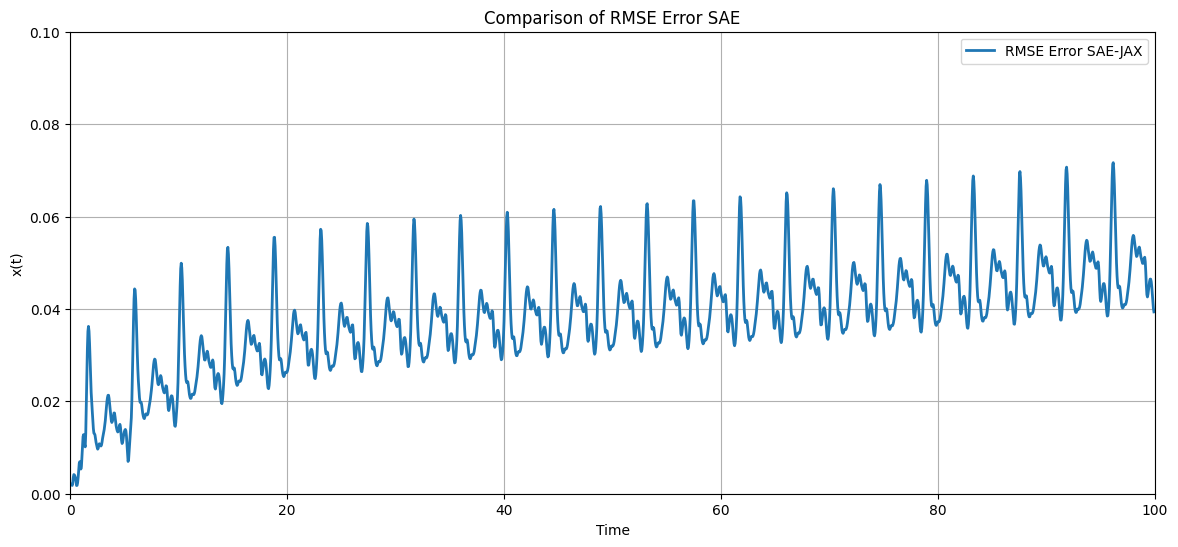

In [52]:
rmse_sae = np.zeros((len(Ux_true),))
rmse_sae_pod = np.zeros((len(Ux_true),))
for i in range(len(Ux_true)):
  rmse_sae[i] = np.sqrt(((Ux_true[i,:]-Ux_reconstructed[i,:]) ** 2).mean())

plt.figure(figsize=(14, 6))
plt.plot(t_train,rmse_sae, label='RMSE Error SAE-JAX', linewidth=2)
plt.xlabel('Time')
plt.xlim(0,100)
plt.ylim(0,0.1)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of RMSE Error SAE')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of RMSE Error SAE-JAX', dpi=300, bbox_inches='tight')
plt.show()

In [53]:

print(Ux_reconstructed.shape)
Ux_reconstructed=Ux_reconstructed.reshape(1998,2,128,64)
Ux_true=Ux_true.reshape(1998,2,128,64)


(1998, 16384)


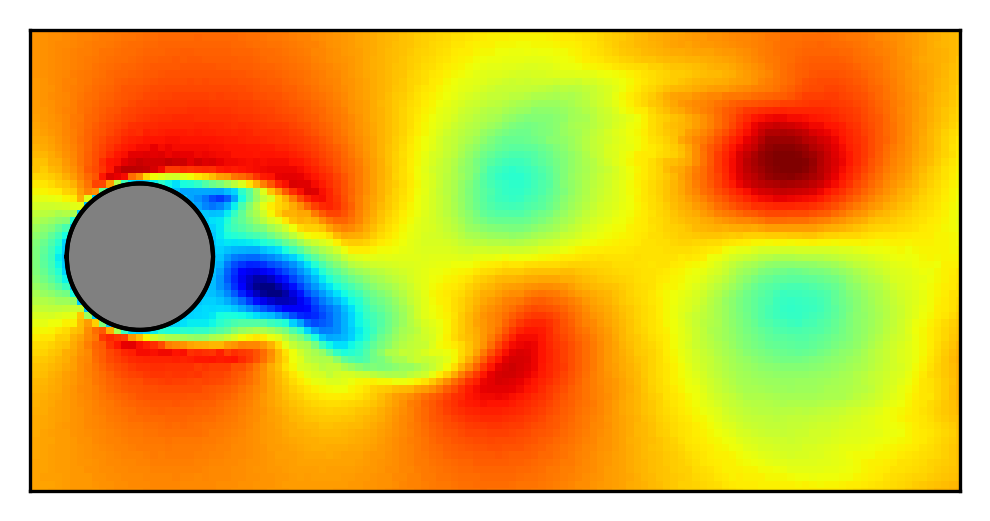

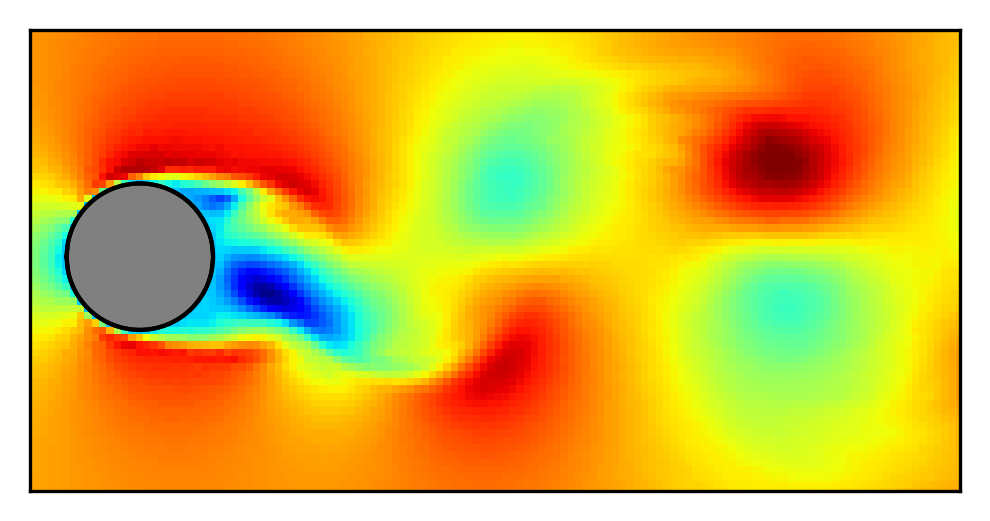

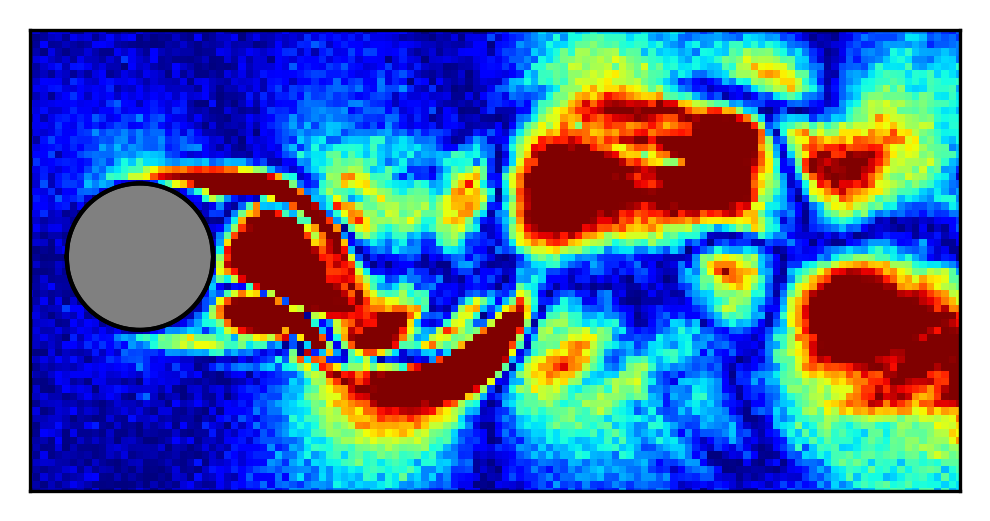

In [54]:
#Comparison of Contrours of Uy velocity at last timestep
t=1997 #98.5 s
contour(Ux_reconstructed[t,0,:,:],'jet',[-0.8,1.7],Xn,Yn)
contour(Ux_true[t,0,:,:],'jet',[-0.8,1.7],Xn,Yn)
contour(abs(Ux_true[t,0,:,:]-Ux_reconstructed[t,0,:,:]),'jet',[0, 0.05],Xn,Yn)


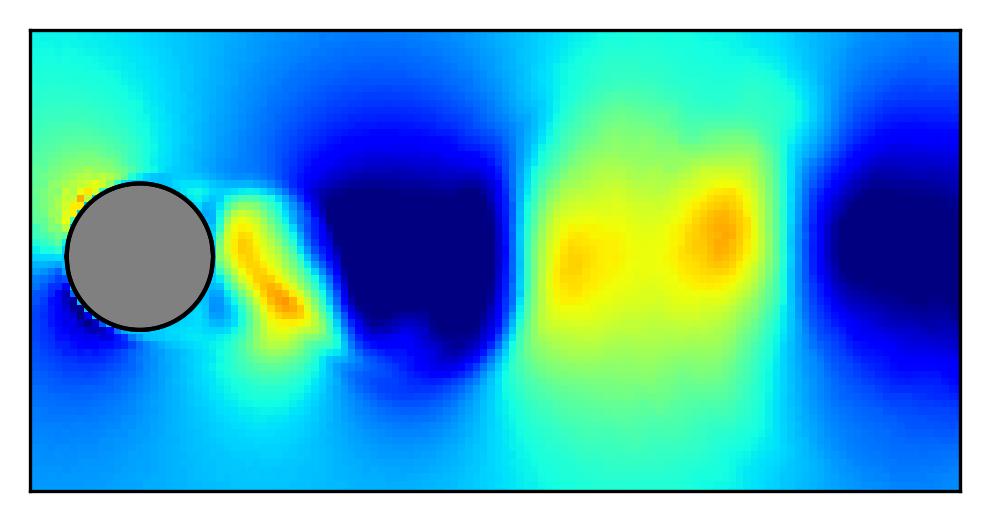

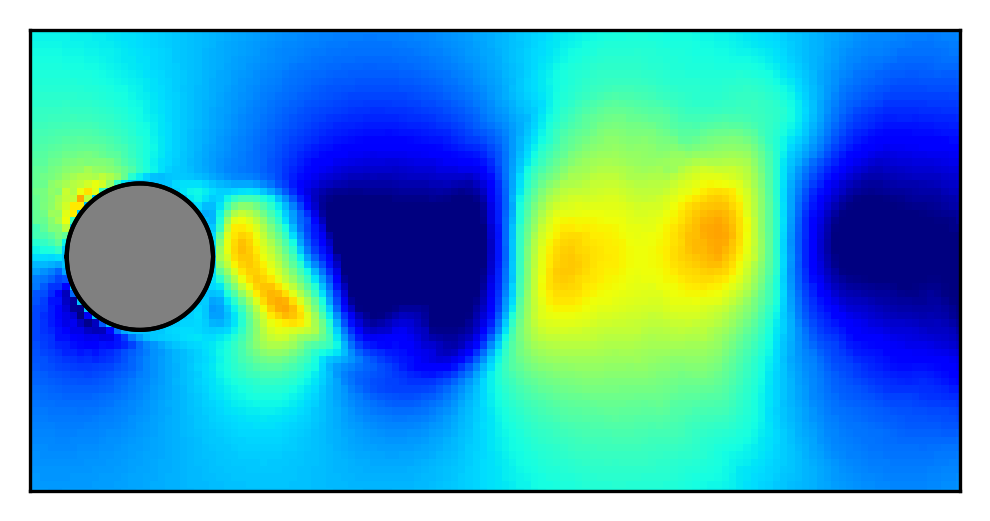

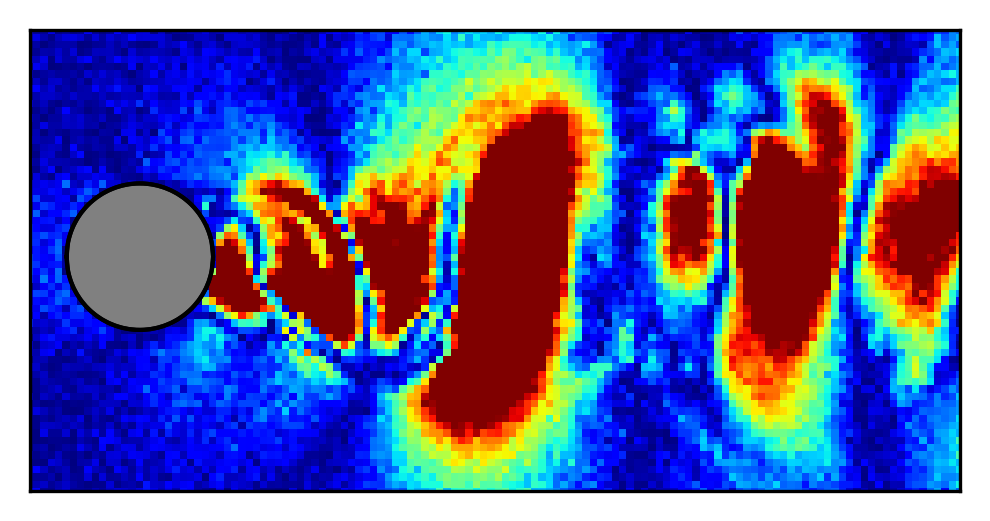

In [55]:
#Comparison of Contrours of Uy velocity at last timestep
t=1997 #98.5 s
contour(Ux_reconstructed[t,1,:,:],'jet',[-0.8,1.7],Xn,Yn)
contour(Ux_true[t,1,:,:],'jet',[-0.8,1.7],Xn,Yn)
contour(abs(Ux_true[t,1,:,:]-Ux_reconstructed[t,1,:,:]),'jet',[0, 0.05],Xn,Yn)